In [15]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import Aer
from qiskit.circuit.library import QFT
from qiskit.circuit.library import ZGate
from qiskit.circuit.library import IntegerComparator
from clc_oracle import apply_clc
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [16]:
# NEED TO CHANGE SO THAT WE CAN PASS IN GRAPH FROM MAIN NOTEBOOK
def generate_tsp_instance(num_cities):
    G = nx.erdos_renyi_graph(num_cities, 0.8)
    for e in G.edges():
        G.add_edge(e[0], e[1], weight=np.round(np.abs(np.random.normal(0,2)),3))
    return G

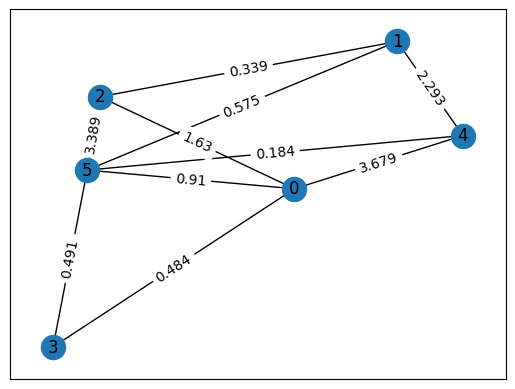

In [18]:
# Define TSP Instance
G = generate_tsp_instance(6)

pos = nx.spring_layout(G)
nx.draw_networkx(G, pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()

In [11]:
m = 2
t = 3
N = 4
i = 0
Iopt = np.pi * np.sqrt(2**(m*N)) / 4
constants = {"m":m, "N":N, "t":t, "i":i, "Iopt":Iopt}

[0.54030231+0.84147098j 0.75390225+0.6569866j  0.96017029-0.2794155j
 1.        +0.j        ]
[ 0.54030231+0.84147098j  0.28366219-0.95892427j -0.65364362-0.7568025j
  1.        +0.j        ]
[ 0.75390225+0.6569866j   0.28366219-0.95892427j -0.65364362-0.7568025j
  1.        +0.j        ]
[ 0.96017029-0.2794155j -0.65364362-0.7568025j -0.65364362-0.7568025j
  1.        +0.j       ]


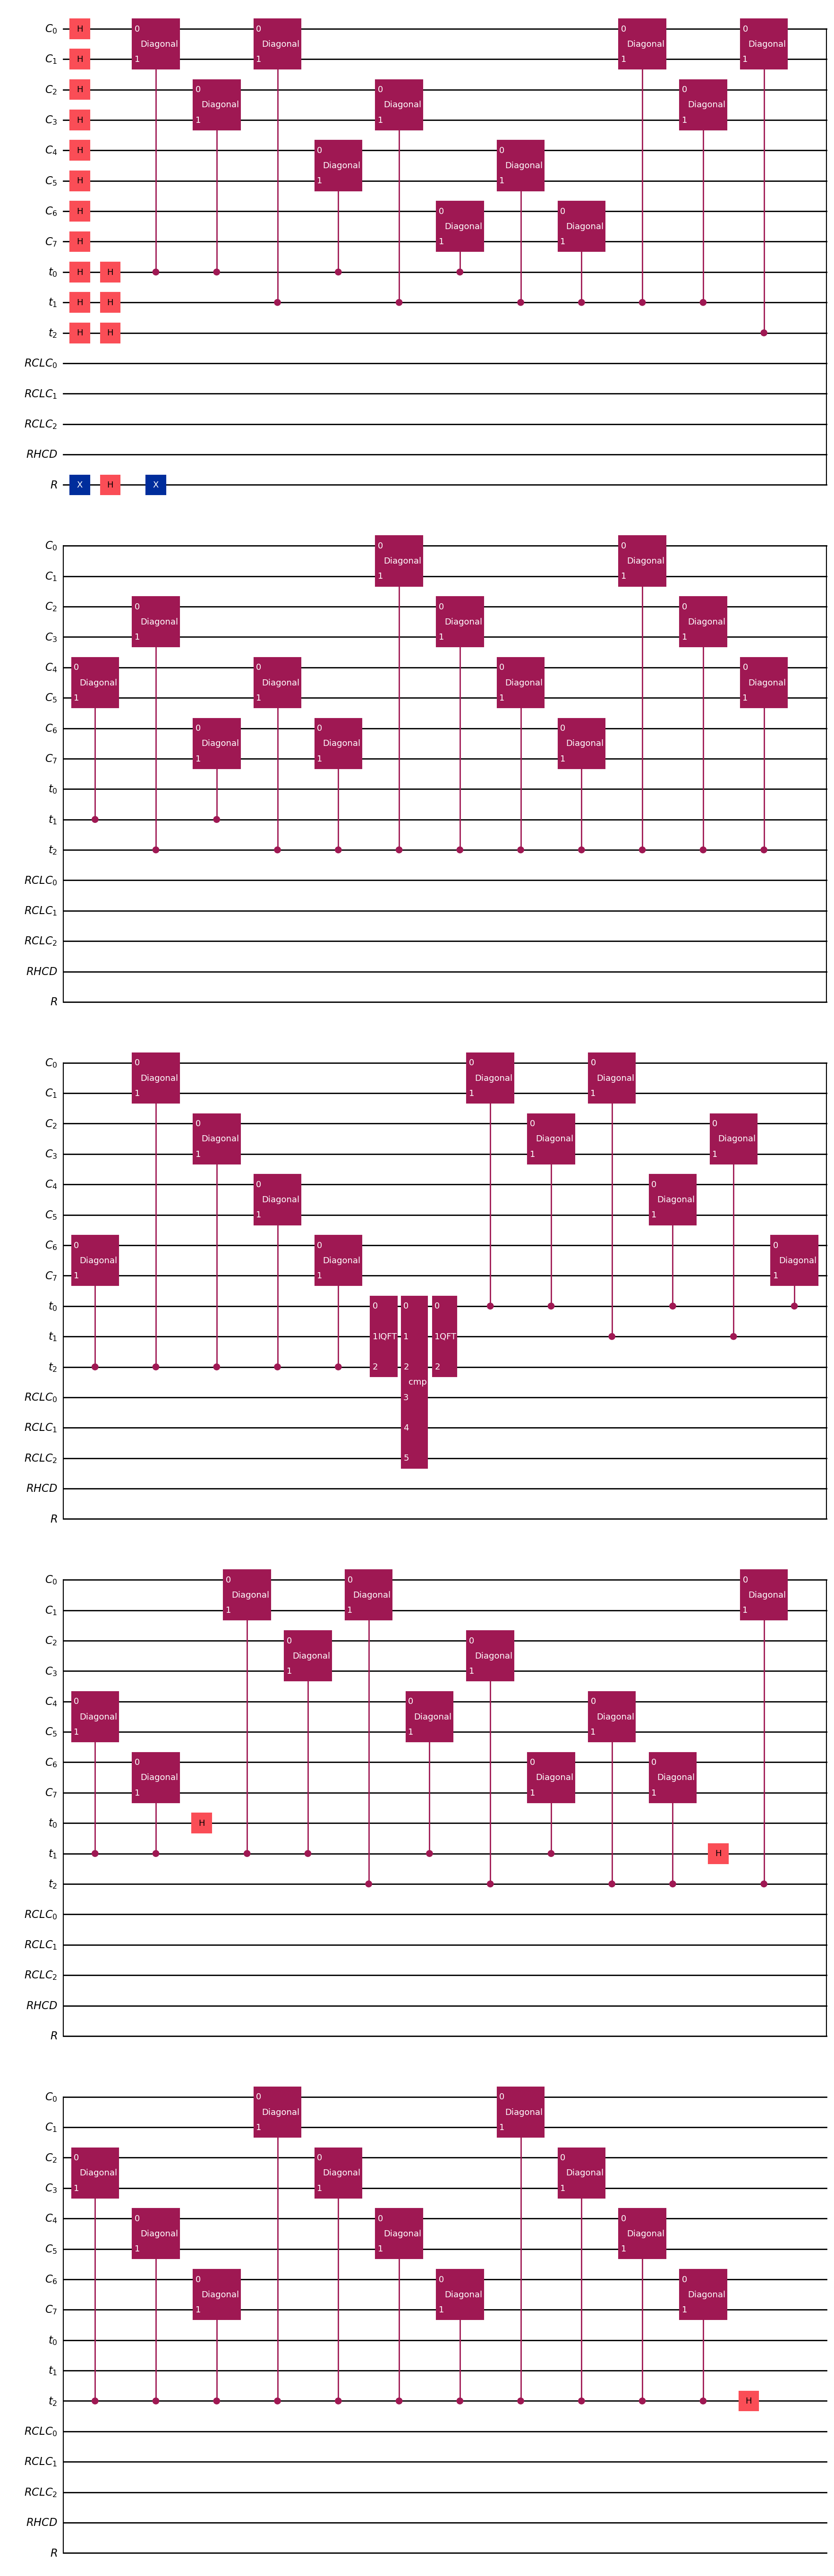

In [12]:
qr_C = QuantumRegister(m*N, 'C')
qr_t = QuantumRegister(t, 't')
qr_RCLC = QuantumRegister(t, 'RCLC')
qr_RHCD = QuantumRegister(1, 'RHCD')
qr_R = QuantumRegister(1, 'R')
registers = {"C":qr_C, "t":qr_t, "R":qr_R, "RCLC":qr_RCLC, "RHCD":qr_RHCD}

TSPcircuit = QuantumCircuit(qr_C, qr_t, qr_RCLC, qr_RHCD, qr_R)

TSPcircuit.x(qr_R)
TSPcircuit.h(qr_R)

for qubit in range(m*N):
    TSPcircuit.h(qr_C[qubit])

for qubit in range(t):
    TSPcircuit.h(qr_t[qubit])

TSPcircuit.x(qr_R)

# Display the circuit
TSPcircuit = apply_clc(TSPcircuit, registers, constants)
TSPcircuit.draw(output='mpl')

In [5]:
sim = Aer.get_backend('qasm_simulator')
new_circuit = transpile(TSPcircuit, backend=sim)
job = sim.run(new_circuit) # Need to determine lower bound on suitable number of shots to take
result = job.result()
paths = result.get_counts()
print(paths)

### Processing Measurements

In [28]:
def bitstring_to_decimal_path(N, bit_path):
    """ 
    Convert bitstring path to decimal path
    """
    m = np.ceil(np.log(N))
    int_path = []
    for i in range(N):
        city = bit_path[i * m : (i + 1) * m]
        print(city)
        int_path.append(int(city,2))
    return int_path

def check_hamiltonian_cycle(bitstring, num_cities, adj_mat, adj_list):
    decimal_path = (num_cities, bitstring)
    cost = 0
    curr_city = 0
    count = 0
    path = [0]
    while (count < num_cities):
        next_city = adj_list[curr_city][decimal_path[curr_city]]
        cost += adj_mat[curr_city, next_city]
        path.append(next_city)
        curr_city = next_city 
        count += 1
    if (len(set(path)) == num_cities and path[0] == path[-1]):
        return True, path, cost
    else:
        return False, path, cost

In [19]:
adj_matrix = nx.adjacency_matrix(G) # Adjacency Matrix for TSP Instance
adj_lists = [[c for c in G[i]] for i in G.nodes()] # Adjacency List for TSP Instance

In [ ]:
counts_to_bitstring = {v : k for k, v in paths.items()}
sorted_counts = np.sort(counts_to_bitstring.keys())
ham_cycles = []
min_cost = len(G) * 2 * np.pi
min_cycle = 0
for count in sorted_counts:
    bitstring = counts_to_bitstring[count]
    is_ham_cycle, path, cost = check_hamiltonian_cycle(bitstring, len(G), adj_matrix, adj_lists)
    if (is_ham_cycle):
        if (cost < min_cost):
            min_cost = cost 
            min_cycle = (bitstring, path)
        ham_cycles.append((bitstring, path, cost))
print(ham_cycles)
print(min_cycle, min_cost)